In [29]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from scipy.stats import spearmanr
import sqlite3
import torch
from tqdm import tqdm

sys.path.insert(0, '../src')
sys.path.insert(1, '..')

from main import get_model
from models.config import Config, IMAGE_TOKEN_IDS
import db_utils, visualizations, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
sys.argv = ['notebooks/get_representations.ipynb',
            '--config', '../configs/models/qwen/Qwen2-VL-2B-Instruct-VisualBlocks.yaml']

config = Config()

In [18]:
model = get_model(config.architecture, config)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


In [5]:
print(model.model)


Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Seq

In [19]:
for name, module in model.model.named_modules():
    if model.config.matches_module(name):
        print(name)

visual.blocks.0
visual.blocks.1
visual.blocks.2
visual.blocks.3
visual.blocks.4
visual.blocks.5
visual.blocks.6
visual.blocks.7
visual.blocks.8
visual.blocks.9
visual.blocks.10
visual.blocks.11
visual.blocks.12
visual.blocks.13
visual.blocks.14
visual.blocks.15
visual.blocks.16
visual.blocks.17
visual.blocks.18
visual.blocks.19
visual.blocks.20
visual.blocks.21
visual.blocks.22
visual.blocks.23
visual.blocks.24
visual.blocks.25
visual.blocks.26
visual.blocks.27
visual.blocks.28
visual.blocks.29
visual.blocks.30
visual.blocks.31
visual.merger


In [20]:
model.run(save_tokens=True)

Running forward hooks on data: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


In [21]:
db_path = model.config.output_db
utils.informal_log(db_path)
connection = sqlite3.connect(db_path)
connection.row_factory = sqlite3.Row
cursor = connection.cursor()

[1014_140536] ../output/Qwen2-VL-2B-Instruct-VisualBlocks.db


In [22]:
for r in cursor.execute("""
  SELECT DISTINCT layer
  FROM tensors
"""):
    print(dict(r))

{'layer': 'input_ids'}
{'layer': 'visual.blocks.0'}
{'layer': 'visual.blocks.1'}
{'layer': 'visual.blocks.2'}
{'layer': 'visual.blocks.3'}
{'layer': 'visual.blocks.4'}
{'layer': 'visual.blocks.5'}
{'layer': 'visual.blocks.6'}
{'layer': 'visual.blocks.7'}
{'layer': 'visual.blocks.8'}
{'layer': 'visual.blocks.9'}
{'layer': 'visual.blocks.10'}
{'layer': 'visual.blocks.11'}
{'layer': 'visual.blocks.12'}
{'layer': 'visual.blocks.13'}
{'layer': 'visual.blocks.14'}
{'layer': 'visual.blocks.15'}
{'layer': 'visual.blocks.16'}
{'layer': 'visual.blocks.17'}
{'layer': 'visual.blocks.18'}
{'layer': 'visual.blocks.19'}
{'layer': 'visual.blocks.20'}
{'layer': 'visual.blocks.21'}
{'layer': 'visual.blocks.22'}
{'layer': 'visual.blocks.23'}
{'layer': 'visual.blocks.24'}
{'layer': 'visual.blocks.25'}
{'layer': 'visual.blocks.26'}
{'layer': 'visual.blocks.27'}
{'layer': 'visual.blocks.28'}
{'layer': 'visual.blocks.29'}
{'layer': 'visual.blocks.30'}
{'layer': 'visual.blocks.31'}
{'layer': 'visual.merger'}


In [26]:
for r in cursor.execute("""
  SELECT id, image_id, timestamp, name, image_path, prompt, label, layer, pooling_method, tensor_dim, tensor_shape,
         length(tensor) AS tensor_bytes
  FROM tensors
  LIMIT 20
"""):
    print(dict(r))

{'id': 1, 'image_id': None, 'timestamp': '2025-10-14 15:20:08', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': None, 'layer': 'input_ids', 'pooling_method': None, 'tensor_dim': 1, 'tensor_shape': 'torch.Size([1, 172])', 'tensor_bytes': 2524}
{'id': 2, 'image_id': None, 'timestamp': '2025-10-14 15:20:08', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': None, 'layer': 'visual.blocks.31', 'pooling_method': None, 'tensor_dim': 1280, 'tensor_shape': 'torch.Size([576, 1280])', 'tensor_bytes': 1475740}
{'id': 3, 'image_id': None, 'timestamp': '2025-10-14 15:20:08', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': No

### For each image, calculate similarity of embeddings between pairs of layers

In [34]:
module_names = []
module_embeddings = []
module_similarities = []
# Get input_ids
input_ids = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="input_ids",
    device="cuda")
input_ids, input_ids_same_shapes = db_utils.unwrap_embeddings(input_ids)

# Get module names:
for name, _ in model.model.named_modules():
    if model.config.matches_module(name):
        module_names.append(name)
        if name.startswith("model."):
            module_names.append("{}-visual".format(name))

# Get embeddings for each layer
for module_name in tqdm(module_names, total=len(module_names)):
    module_embedding = db_utils.get_embeddings_by_layer(
        db_path=db_path,
        layer_name=module_name
    )
    module_embedding, module_embedding_same_shapes = db_utils.unwrap_embeddings(module_embedding)

    # Compute mean embedding of visual tokens only (if applicable)
    if module_name.endswith("-visual"):
        module_visual_embedding, n_visual_tokens = db_utils.extract_visual_embeddings(
            input_ids=input_ids,
            llm_embeddings=module_embedding,
            image_token_id=IMAGE_TOKEN_IDS[config.architecture],
            same_shapes=module_embedding_same_shapes
        )
        # Calculate mean embedding
        visual_mean_embeddings = db_utils.compute_mean_embeddings(
            embeddings=module_visual_embedding,
            n_embeddings=n_visual_tokens)
        module_embeddings.append(visual_mean_embeddings)

    # Calculate mean embedding
    mean_embeddings = db_utils.compute_mean_embeddings(
        embeddings=module_embedding)

    module_embeddings.append(mean_embeddings)

    # Calculate similarities of pairs of images
    module_sim = db_utils.cosine_similarity_numpy(mean_embeddings, mean_embeddings)
    # Assert similarity is symmetric
    assert np.array_equal(module_sim, module_sim.T)

    # Select only Upper Triangular Matrix
    n_samples = module_sim.shape[0]
    ut_idxs = np.triu_indices(n_samples, k=1)
    sim_values = module_sim[ut_idxs]
    assert len(sim_values) == n_samples * (n_samples - 1) / 2
    # Store values in list
    module_similarities.append(sim_values)



  0%|          | 0/33 [00:00<?, ?it/s]

100%|██████████| 33/33 [00:06<00:00,  5.25it/s]


<Figure size 640x480 with 0 Axes>

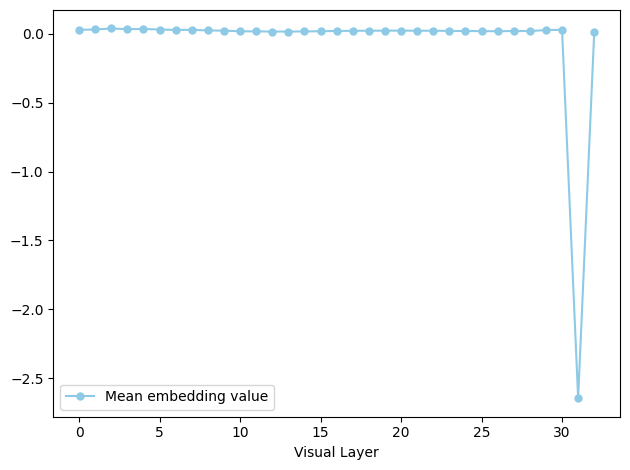

<Figure size 640x480 with 0 Axes>

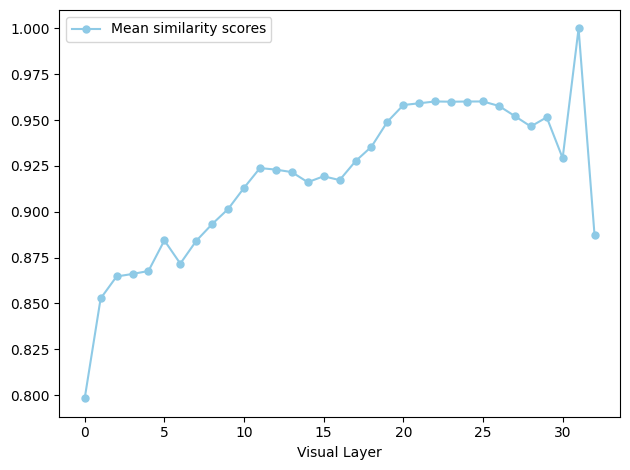

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Visual Layer'>)

In [40]:
# For each layer, calculate the mean similarity and the norm
mean_embeddings = []
mean_similarities = []
for idx, (name, embs, sims) in enumerate(zip(module_names, module_embeddings, module_similarities)):
    mean_embeddings.append(np.mean(embs))
    mean_similarities.append(np.mean(sims))

visualizations.plot(
    xs=[[i for i in range(len(mean_embeddings))]],
    ys=[mean_embeddings],
    labels=['Mean embedding value',],
    xlabel='Visual Layer',
    show=True
)
visualizations.plot(
    xs=[[i for i in range(len(mean_embeddings))]],
    ys=[mean_similarities],
    labels=['Mean similarity scores'],
    xlabel='Visual Layer',
    show=True
)


In [ ]:
# Compare embeddings across each pair of layers
comparison_names = []
cosine_sims = []
for i in range(n_modules - 1):
    for j in range(i + 1, n_modules):
        # Check embeddings are same dimensions
        embedding_i = module_embeddings[i]
        embedding_j = module_embeddings[j]
        if not embedding_i.shape == embedding_j.shape:
            continue

        name_i = module_names[i]
        name_j = module_names[j]

        # Calculate cosine sim
        cosine_sim = db_utils.cosine_similarity_numpy(embedding_i, embedding_j)
        # Only want diagonal because that is comparing same image to same image
        cosine_sim = np.diag(cosine_sim)

        comparison_names.append("{}\n\/\n{}".format(name_i, name_j))
        cosine_sims.append(cosine_sim)

2 rows; 4 columns


/n/fs/ac-vlm/vlm-lens/notebooks/../src/visualizations.py:828: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


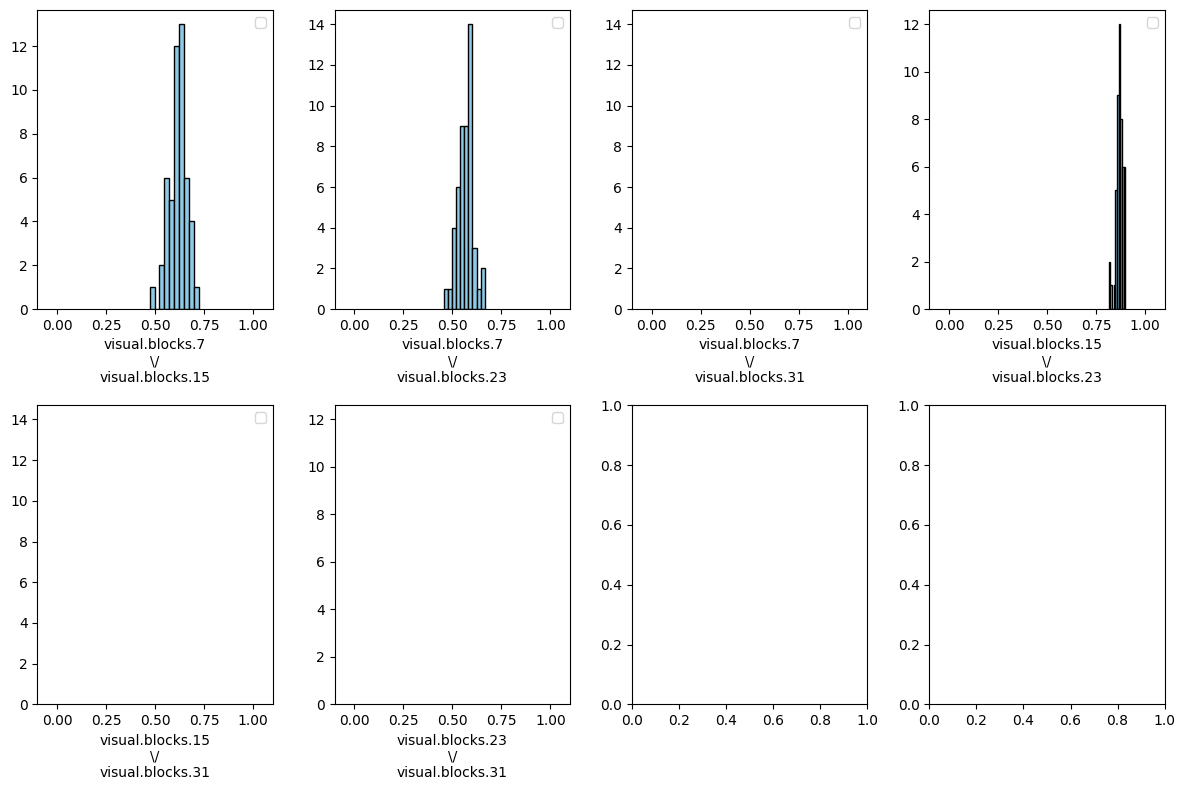

In [11]:
# Graph histograms of similarity scores for each pair of layers
n_graphs = len(comparison_names)
n_cols = 4
n_rows = n_graphs // n_cols + 1
print("{} rows; {} columns".format(n_rows, n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 4 * n_rows))

graph_idx = 0
# for idx in range(n_graphs):
for row_idx in range(n_rows):
    if graph_idx >= n_graphs:
        break
    for col_idx in range(n_cols):
        if graph_idx >= n_graphs:
            break
        if n_rows > 1:
            ax = axes[row_idx][col_idx]
        else:
            ax = axes[col_idx]
        comparison_name = comparison_names[graph_idx]
        cosine_sim = cosine_sims[graph_idx]

        fig, ax, _ = visualizations.histogram(
            data=cosine_sim,
            fig=fig,
            ax=ax,
            xlim=[-0.1, 1.1],
            xlabel=comparison_name,
            show=False
        )
        if n_rows > 1:
            axes[row_idx][col_idx] = ax
        else:
            axes[col_idx] = ax
        graph_idx += 1
plt.tight_layout()
plt.show()

### For each pair of images, calculate similarity at relevant layers

In [12]:
for name, embs in zip(module_names, module_embeddings):
    print(name, embs.shape)

visual.blocks.7 (50, 1280)
visual.blocks.15 (50, 1280)
visual.blocks.23 (50, 1280)
visual.blocks.31 (50, 1280)
visual.merger (50, 1536)


(50,)
(50,)
(50,)
(50,)
(50,)


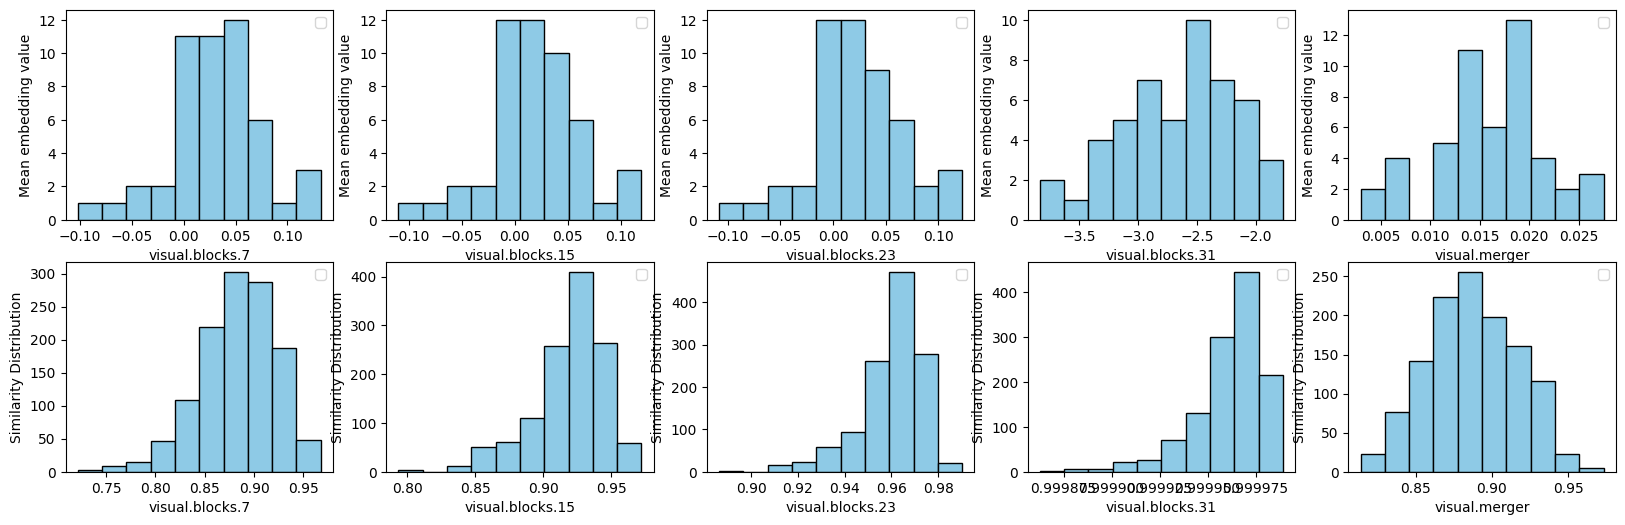

In [13]:
# For each layer
module_similarities = []
plot_histograms = True
if plot_histograms:
    fig, axes = plt.subplots(nrows=2, ncols=len(module_names), figsize=(4*len(module_names), 6))
for idx, (name, embs) in enumerate(zip(module_names, module_embeddings)):
    # if name == "visual.blocks.31":
    #     print(type(embs))
    #     norm = np.linalg.norm(embs, ord=2, axis=1, keepdims=True)
    #     # Add epsilon to avoid division by zero
    #     norm = np.maximum(norm, 1e-6)

    #     # Divide the input array by its norm
    #     embs = embs / norm
    # Compute similarity with same matrix
    module_sim = db_utils.cosine_similarity_numpy(embs, embs)
    # Assert similarity is symmetric
    assert np.array_equal(module_sim, module_sim.T)

    # if name == "visual.blocks.31":
    #     print(embs[:5, :5])
    #     print(module_sim[:5, :5])
    #     print(np.mean(module_sim))
    # Get Upper Triangular Matrix values (excluding diagonal) and flatten
    n_samples = module_sim.shape[0]
    ut_idxs = np.triu_indices(n_samples, k=1)
    sim_values = module_sim[ut_idxs]
    assert len(sim_values) == n_samples * (n_samples - 1) / 2
    # Store values in list
    module_similarities.append(sim_values)

    if plot_histograms:
        print(np.mean(embs, axis=1).shape)
        # mean value of embeddings values
        fig, axes[0, idx], _ = visualizations.histogram(
            # sim_values.flatten(),
            np.mean(embs, axis=1),
            ylabel="Mean embedding value",
            xlabel=name,
            fig=fig,
            ax=axes[0, idx],
            show=False)

        # Similarity values
        fig, axes[1, idx], _ = visualizations.histogram(
            sim_values.flatten(),
            ylabel="Similarity Distribution",
            xlabel=name,
            fig=fig,
            ax=axes[1, idx],
            show=False)
plt.show()



15 graphs


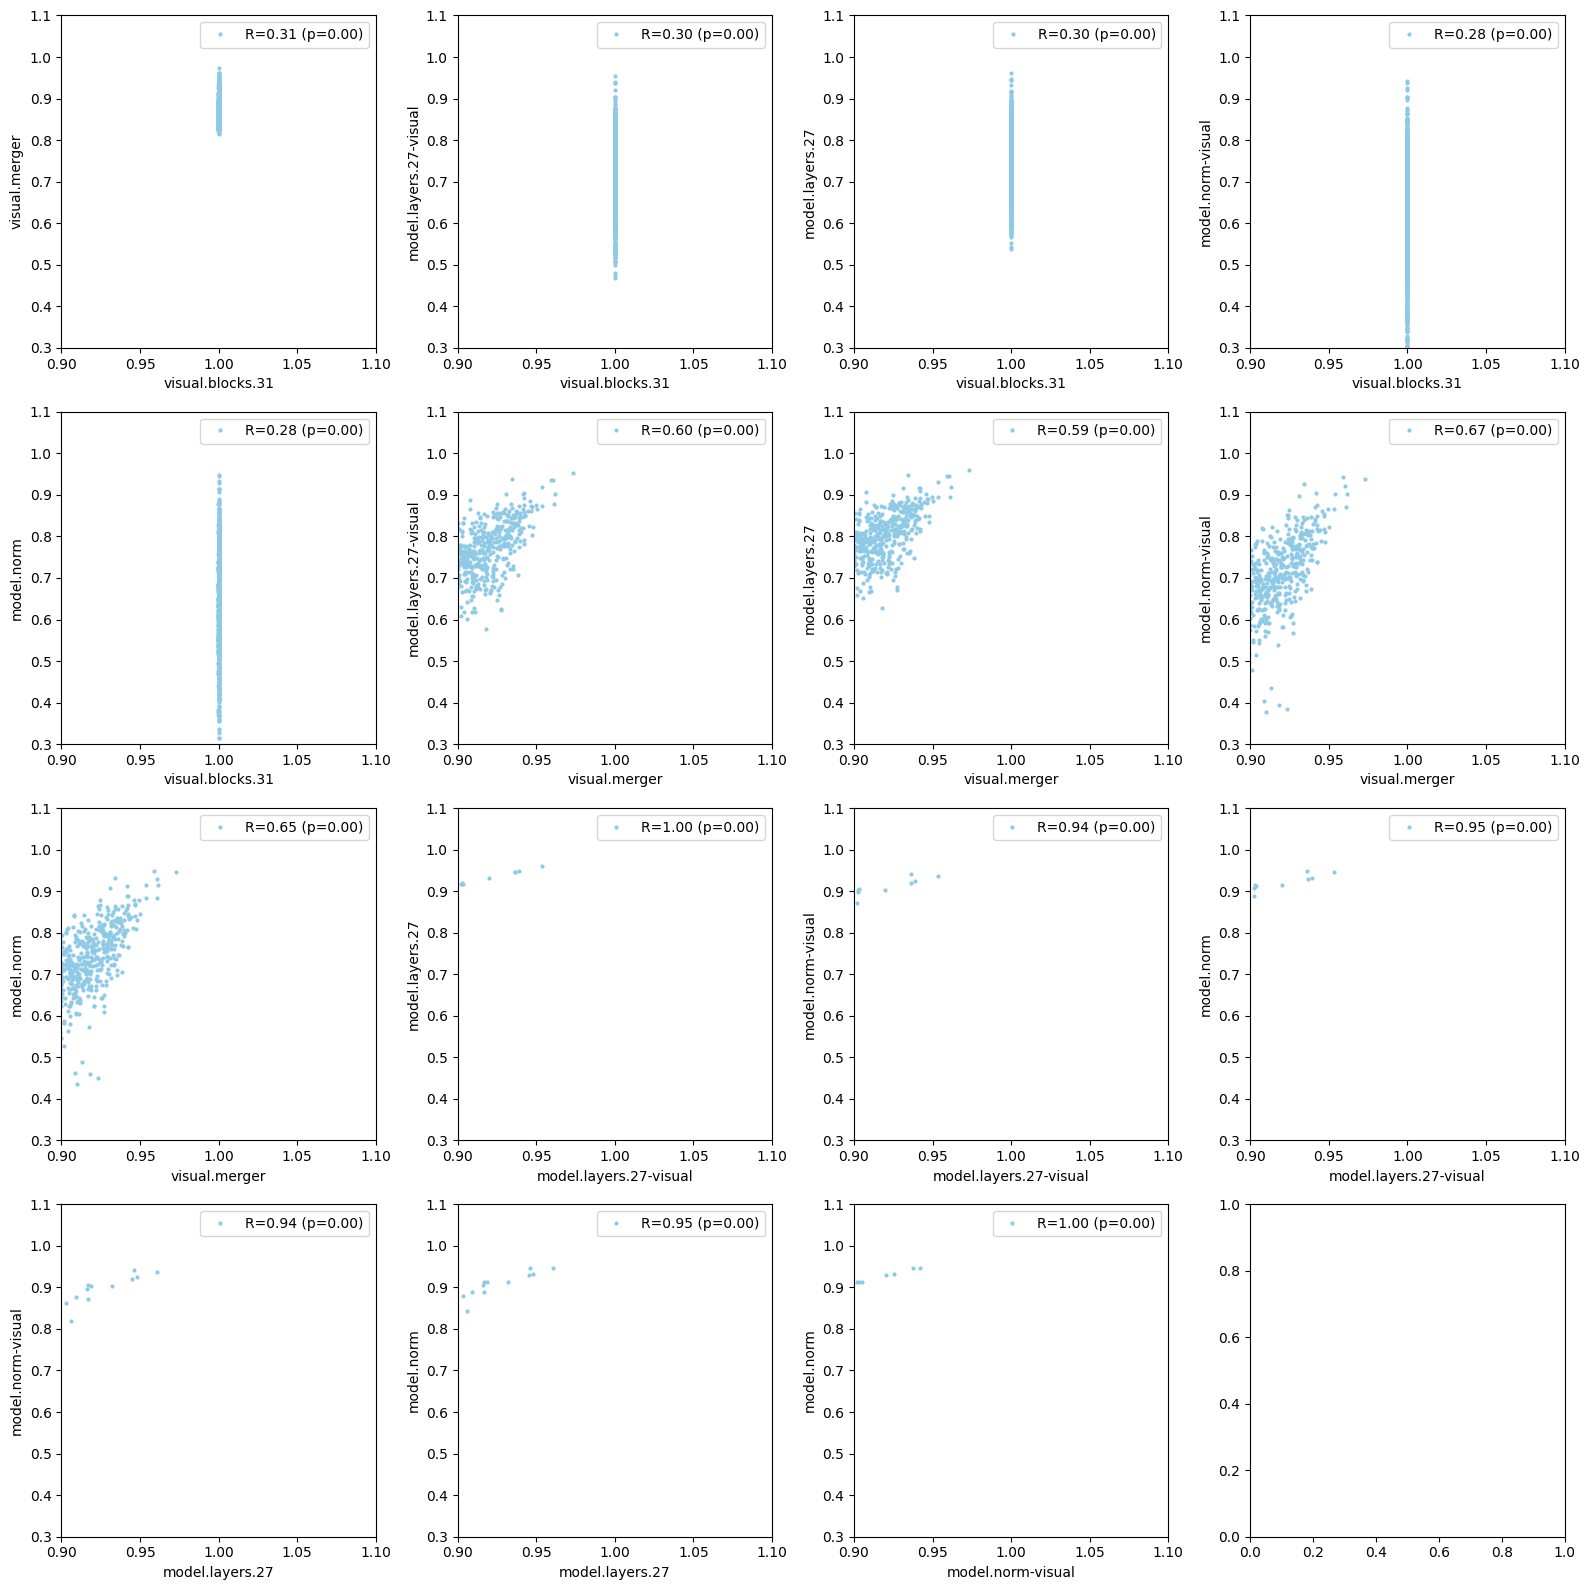

In [ ]:
n_layers = len(module_names)
n_graphs = int(n_layers * (n_layers - 1) / 2)

print("{} graphs".format(n_graphs))
n_cols = 4
n_rows = n_graphs // n_cols
if n_graphs % n_cols != 0:
    n_rows += 1
# For each pair of layers
row_idx = 0
col_idx = 0

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4 * n_cols, 4 * n_rows))
for layer_i in range(n_layers - 1):
    for layer_j in range(layer_i + 1, n_layers):
        if n_rows > 1:
            ax = axes[row_idx, col_idx]
        else:
            ax = axes[col_idx]
        name_i = module_names[layer_i]
        name_j = module_names[layer_j]

        sim_i = module_similarities[layer_i]
        sim_j = module_similarities[layer_j]

        # Calculate correlation
        corr, pval = spearmanr(sim_i, sim_j)

        fig, ax = visualizations.plot(
            fig=fig,
            ax=ax,
            xs=[sim_i],
            ys=[sim_j],
            line=False,
            marker_size=2,
            xlabel=name_i,
            ylabel=name_j,
            xlimits=[0.3, 1.1],
            ylimits=[0.3, 1.1],
            labels=['R={:.2f} (p={:.2f})'.format(corr, pval)]
        )
        if n_rows > 1:
            axes[row_idx, col_idx] = ax
        else:
            axes[col_idx] = ax

        # Update row and column idxs
        col_idx += 1
        if col_idx == n_cols:
            col_idx = 0
            row_idx += 1

plt.show()

In [ ]:
# Visualize samples that are different between visual.merger and model.norm-visual, n_visualize
layer1 = "visual.merger"
layer2 = "model.norm-visual"
n_visualize = 5
modes = ["max", "min"]

# Make a dictionary keyed by names
similarities_dict = dict(zip(module_names, module_similarities))
# Obtain similarity matrices

sims1 = similarities_dict[layer1]
sims2 = similarities_dict[layer2]

# Calculate differences (layer1 - layer2)
diff12 = sims1 - sims2
didff21 = sims2 - sims1

# get indices for top n_visualize differences

# visualize

# get indices for bottom n_visualize differences

# visualize